# Lesson 2: A* & Informed Search | Heuristics and optimality

## Section 1: Introduction to Informed Search

In the previous lesson, we explored uninformed search algorithms like Breadth-First Search (BFS) and Depth-First Search (DFS). These algorithms explore the search space without any additional knowledge about the problem domain beyond the basic graph structure.

**Informed search algorithms**, also known as heuristic search algorithms, use problem-specific knowledge to guide the search towards the goal more efficiently. This additional information is provided in the form of a heuristic function that estimates the cost from any state to the goal state.

**Key differences between uninformed and informed search:**

- **Uninformed search**: Blind exploration, no domain knowledge
- **Informed search**: Uses heuristics to guide exploration, potentially much more efficient

The most famous informed search algorithm is **A*** (pronounced "A-star"), which combines the advantages of both Dijkstra's algorithm (which finds shortest paths) and greedy best-first search (which uses heuristics).

This lesson will cover:
1. Heuristic functions and their properties
2. The A* algorithm in detail
3. Implementation with examples
4. Optimality guarantees
5. Comparison with uninformed search

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import heapq
from typing import List, Tuple, Dict, Set
import time

## Section 2: Heuristics

A **heuristic function** $h(n)$ estimates the cost of the cheapest path from node $n$ to a goal node. The quality of a heuristic determines how effectively it guides the search.

### Properties of Heuristics

**Admissible Heuristic**: A heuristic $h(n)$ is admissible if it never overestimates the true cost to reach the goal. That is, $h(n) \leq h^*(n)$ for all $n$, where $h^*(n)$ is the true cost.

**Consistent Heuristic**: A heuristic $h(n)$ is consistent (or monotone) if for every node $n$ and every successor $n'$ of $n$ generated by action $a$:
$h(n) \leq c(n, a, n') + h(n')$

**Why admissibility matters**: If $h$ is admissible, A* is guaranteed to find an optimal solution.

### Common Heuristics for Pathfinding

For grid-based pathfinding problems, common heuristics include:

1. **Manhattan Distance**: $|x_1 - x_2| + |y_1 - y_2|$ (for grids where only horizontal/vertical moves are allowed)
2. **Euclidean Distance**: $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$ (straight-line distance)
3. **Chebyshev Distance**: $\max(|x_1 - x_2|, |y_1 - y_2|)$ (for grids allowing diagonal moves)

Let's create a simple grid world to demonstrate these concepts.

In [3]:
class GridWorld:
    def __init__(self, width=10, height=10):
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width))
        self.start = (0, 0)
        self.goal = (height-1, width-1)
        # Add some obstacles
        self.obstacles = [(2, 2), (2, 3), (2, 4), (5, 5), (5, 6), (6, 5), (6, 6)]
        for obs in self.obstacles:
            if obs[0] < height and obs[1] < width:
                self.grid[obs[0], obs[1]] = 1

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < self.height and 0 <= y < self.width and self.grid[x, y] != 1

    def get_neighbors(self, pos):
        x, y = pos
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-directional movement
            nx, ny = x + dx, y + dy
            if self.is_valid_position((nx, ny)):
                neighbors.append((nx, ny))
        return neighbors

    def manhattan_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def euclidean_distance(self, pos1, pos2):
        return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

    def chebyshev_distance(self, pos1, pos2):
        return max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1]))

# Create a grid world
grid_world = GridWorld(8, 8)
print(f"Start: {grid_world.start}, Goal: {grid_world.goal}")
print(f"Obstacles: {grid_world.obstacles}")

Start: (0, 0), Goal: (7, 7)
Obstacles: [(2, 2), (2, 3), (2, 4), (5, 5), (5, 6), (6, 5), (6, 6)]


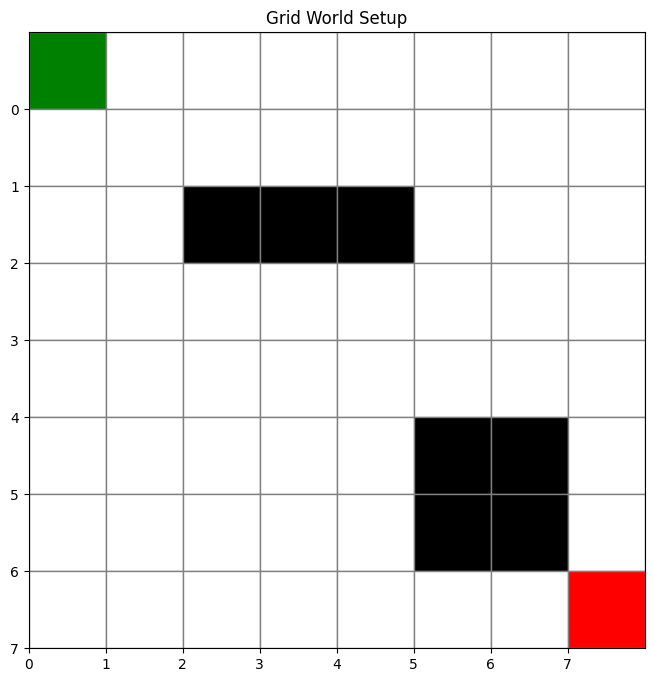

In [4]:
def visualize_grid(grid_world, path=None, explored=None, title="Grid World", show_path_line=False):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create the grid
    for i in range(grid_world.height):
        for j in range(grid_world.width):
            color = 'white'
            if (i, j) in grid_world.obstacles:
                color = 'black'
            elif (i, j) == grid_world.start:
                color = 'green'
            elif (i, j) == grid_world.goal:
                color = 'red'
            elif explored and (i, j) in explored:
                color = 'lightblue'
            elif path and (i, j) in path:
                color = 'yellow'

            rect = patches.Rectangle((j, grid_world.height-1-i), 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)

    # Draw red line connecting path nodes if requested
    if show_path_line and path and len(path) > 1:
        # Convert path coordinates to plot coordinates (flip y-axis)
        path_x = [pos[1] + 0.5 for pos in path]  # x coordinates + 0.5 for center
        path_y = [grid_world.height - 1 - pos[0] + 0.5 for pos in path]  # flip y and +0.5 for center

        ax.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

    ax.set_xlim(0, grid_world.width)
    ax.set_ylim(0, grid_world.height)
    ax.set_aspect('equal')
    ax.set_xticks(range(grid_world.width))
    ax.set_yticks(range(grid_world.height))
    ax.set_xticklabels(range(grid_world.width))
    ax.set_yticklabels(range(grid_world.height-1, -1, -1))
    ax.set_title(title)
    plt.show()

# Visualize the grid world
visualize_grid(grid_world, title="Grid World Setup")

### Visualization Legend

- **Green square**: Start position
- **Red square**: Goal position
- **Black squares**: Obstacles
- **Light blue squares**: Explored nodes (nodes visited during search)
- **Yellow squares**: Final path nodes
- **Red line**: Connected path showing the solution route

The red line makes it easy to follow the complete path from start to goal, clearly showing how each algorithm navigates through the maze.

## Section 3: The A* Algorithm

A* is an informed search algorithm that finds the shortest path between a start node and a goal node. It combines:

1. **$g(n)$**: The cost to reach node $n$ from the start
2. **$h(n)$**: The estimated cost from $n$ to the goal (heuristic)
3. **$f(n) = g(n) + h(n)$**: The total estimated cost of the path through $n$

### How A* Works

A* maintains two sets:
- **Open set**: Nodes to be evaluated (priority queue ordered by $f(n)$)
- **Closed set**: Nodes already evaluated

**Algorithm steps:**
1. Initialize open set with start node, $g(\text{start}) = 0$, $f(\text{start}) = h(\text{start})$
2. While open set is not empty:
   - Remove node with lowest $f(n)$ from open set
   - If this node is goal, reconstruct path
   - For each neighbor:
     - Calculate tentative $g = g(\text{current}) + \text{cost}(\text{current}, \text{neighbor})$
     - If neighbor not in open set or tentative $g < g(\text{neighbor})$:
       - Set parent of neighbor to current
       - Update $g(\text{neighbor})$ and $f(\text{neighbor})$
       - Add neighbor to open set

### Pseudocode

```
function A*(start, goal):
    open_set = {start}
    closed_set = {}
    g_score[start] = 0
    f_score[start] = h(start)
    parent[start] = None

    while open_set is not empty:
        current = node in open_set with lowest f_score
        if current == goal:
            return reconstruct_path(parent, goal)

        remove current from open_set
        add current to closed_set

        for neighbor in neighbors(current):
            if neighbor in closed_set:
                continue

            tentative_g = g_score[current] + distance(current, neighbor)

            if neighbor not in open_set or tentative_g < g_score[neighbor]:
                parent[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = g_score[neighbor] + h(neighbor)
                if neighbor not in open_set:
                    add neighbor to open_set

    return failure
```

Let's implement A* with different heuristics.

In [5]:
def a_star(grid_world, heuristic_func):
    """
    A* search algorithm implementation.

    Args:
        grid_world: GridWorld instance
        heuristic_func: Function that takes two positions and returns heuristic cost

    Returns:
        path: List of positions from start to goal
        explored: Set of explored positions
        g_scores: Dictionary of g-scores for visualization
    """
    start = grid_world.start
    goal = grid_world.goal

    # Priority queue for open set: (f_score, position)
    open_set = []
    heapq.heappush(open_set, (0, start))

    # Dictionaries to keep track of scores
    g_score = {start: 0}
    f_score = {start: heuristic_func(start, goal)}

    # Parent dictionary for path reconstruction
    parent = {start: None}

    # Closed set
    closed_set = set()

    # Explored set for visualization
    explored = set()

    while open_set:
        # Get node with lowest f_score
        current_f, current = heapq.heappop(open_set)

        if current in closed_set:
            continue

        explored.add(current)
        closed_set.add(current)

        if current == goal:
            # Reconstruct path
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path, explored, g_score

        for neighbor in grid_world.get_neighbors(current):
            if neighbor in closed_set:
                continue

            # Cost to move to neighbor (assuming uniform cost of 1)
            tentative_g = g_score[current] + 1

            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                parent[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic_func(neighbor, goal)

                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None, explored, g_score  # No path found

# Test A* with Manhattan distance
path_manhattan, explored_manhattan, g_scores_manhattan = a_star(grid_world, grid_world.manhattan_distance)

if path_manhattan:
    print(f"Path found with Manhattan heuristic! Length: {len(path_manhattan)}")
    print(f"Path: {path_manhattan}")
    print(f"Nodes explored: {len(explored_manhattan)}")
else:
    print("No path found!")

Path found with Manhattan heuristic! Length: 15
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7)]
Nodes explored: 57


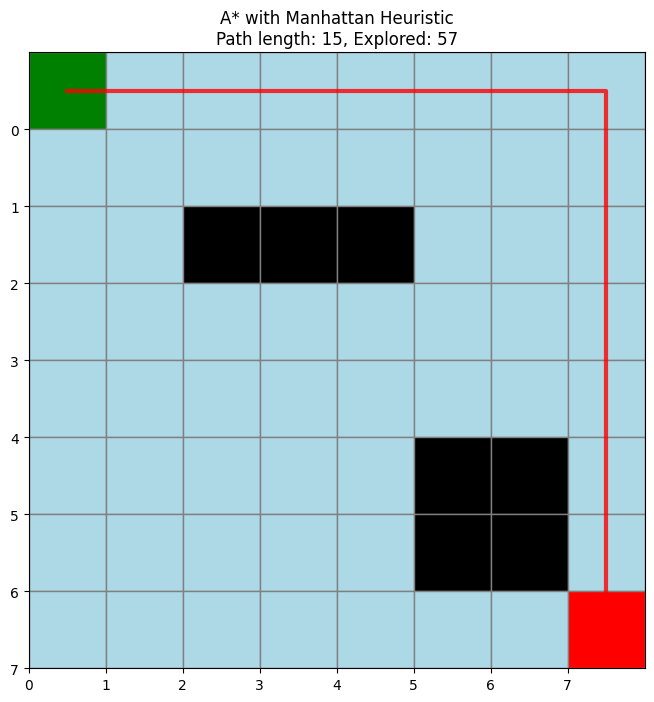

In [6]:
# Visualize A* with Manhattan heuristic
visualize_grid(grid_world, path=path_manhattan, explored=explored_manhattan,
               title=f"A* with Manhattan Heuristic\nPath length: {len(path_manhattan)}, Explored: {len(explored_manhattan)}",
               show_path_line=True)

## Section 4: Comparing Different Heuristics

Let's compare A* performance with different heuristics: Manhattan, Euclidean, and Chebyshev distances. We'll also compare with a "null heuristic" ($h(n) = 0$), which makes A* equivalent to Dijkstra's algorithm.

Null (Dijkstra): Path length = 15, Explored = 57
Manhattan: Path length = 15, Explored = 57
Euclidean: Path length = 15, Explored = 57
Chebyshev: Path length = 15, Explored = 57


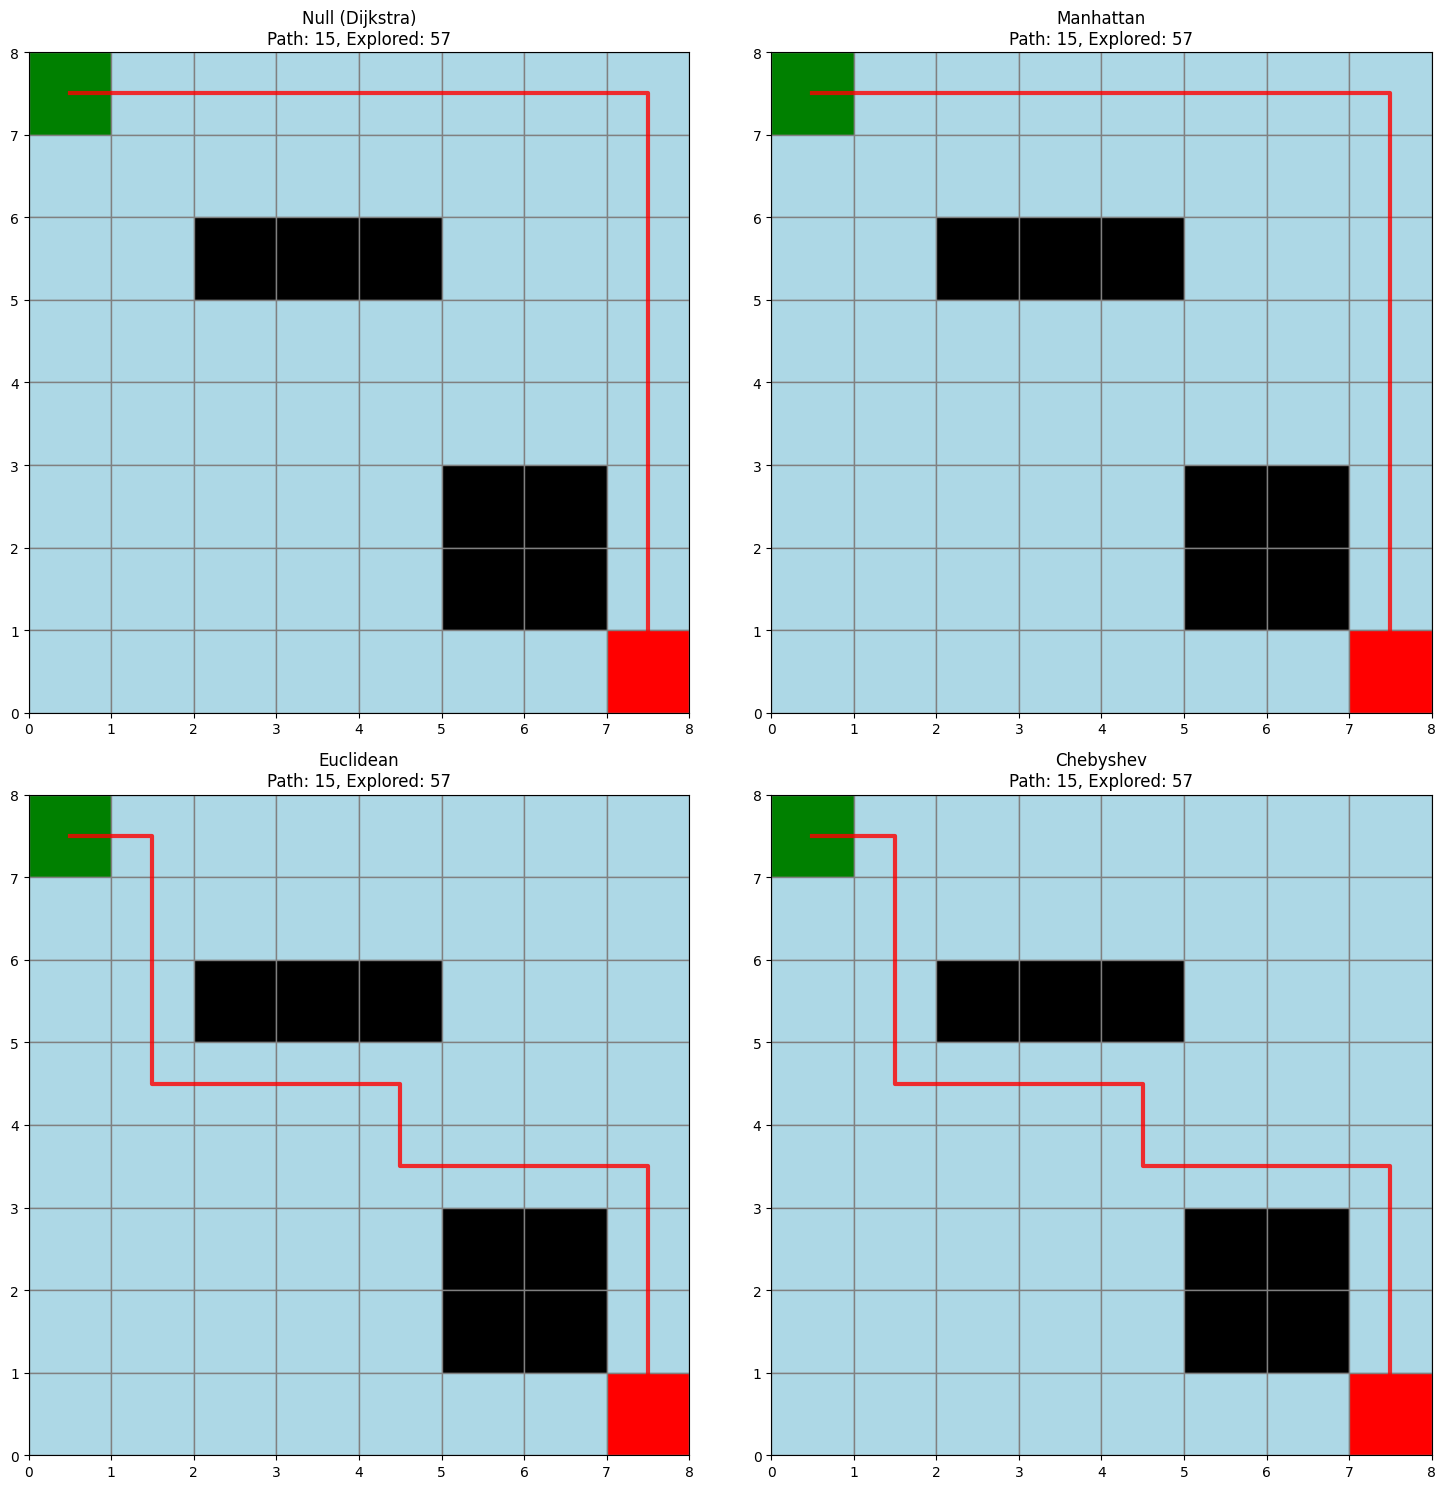

In [7]:
# Compare different heuristics
def null_heuristic(pos1, pos2):
    return 0

heuristics = {
    "Null (Dijkstra)": null_heuristic,
    "Manhattan": grid_world.manhattan_distance,
    "Euclidean": grid_world.euclidean_distance,
    "Chebyshev": grid_world.chebyshev_distance
}

results = {}

for name, heuristic in heuristics.items():
    path, explored, g_scores = a_star(grid_world, heuristic)
    results[name] = {
        "path": path,
        "explored": explored,
        "path_length": len(path) if path else 0,
        "explored_count": len(explored)
    }
    print(f"{name}: Path length = {len(path) if path else 0}, Explored = {len(explored)}")

# Create subplots to compare visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    ax = axes[i]

    # Create the grid
    for x in range(grid_world.height):
        for y in range(grid_world.width):
            color = 'white'
            if (x, y) in grid_world.obstacles:
                color = 'black'
            elif (x, y) == grid_world.start:
                color = 'green'
            elif (x, y) == grid_world.goal:
                color = 'red'
            elif result["explored"] and (x, y) in result["explored"]:
                color = 'lightblue'
            elif result["path"] and (x, y) in result["path"]:
                color = 'yellow'

            rect = patches.Rectangle((y, grid_world.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)

    # Draw red line connecting path nodes for final results
    if result["path"] and len(result["path"]) > 1:
        path_x = [pos[1] + 0.5 for pos in result["path"]]
        path_y = [grid_world.height - 1 - pos[0] + 0.5 for pos in result["path"]]
        ax.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

    ax.set_xlim(0, grid_world.width)
    ax.set_ylim(0, grid_world.height)
    ax.set_aspect('equal')
    ax.set_title(f'{name}\nPath: {result["path_length"]}, Explored: {result["explored_count"]}')

plt.tight_layout()
plt.show()

## Section 5: Optimality and Admissibility



### Why A* is Optimal

When the heuristic function $h(n)$ is **admissible** (never overestimates the true cost), A* is guaranteed to find the optimal path. This is because:

1. A* expands nodes in order of increasing $f(n) = g(n) + h(n)$
2. When the goal is first selected for expansion, no other path can have a lower cost because:
   - Any unexpanded node $m$ must have $f(m) \geq f(\text{goal})$
   - Since $h$ is admissible: $f(m) = g(m) + h(m) \geq g(m) + h^*(m) \geq h^*(\text{goal})$
   - But $f(\text{goal}) = g(\text{goal}) + h(\text{goal}) \leq g(\text{goal}) + h^*(\text{goal}) = h^*(\text{goal})$
   - Therefore, $f(m) \geq f(\text{goal})$, so goal has the lowest $f$-value

### Admissibility Examples

- **Manhattan distance** is admissible for grid paths with only horizontal/vertical moves
- **Euclidean distance** is admissible for any path (since straight-line is shortest possible)
- **Chebyshev distance** is admissible for grids allowing diagonal moves

### Inadmissible Heuristics

If $h(n)$ can overestimate the true cost, A* may not find the optimal path. For example, if we use Euclidean distance but only allow horizontal/vertical moves, the heuristic overestimates the true cost.

Let's demonstrate this with an inadmissible heuristic.

Inadmissible heuristic: Path length = 15, Explored = 16
Optimal path length (Manhattan): 15
Path difference: 0 steps
Very inadmissible heuristic: Path length = 15, Explored = 15


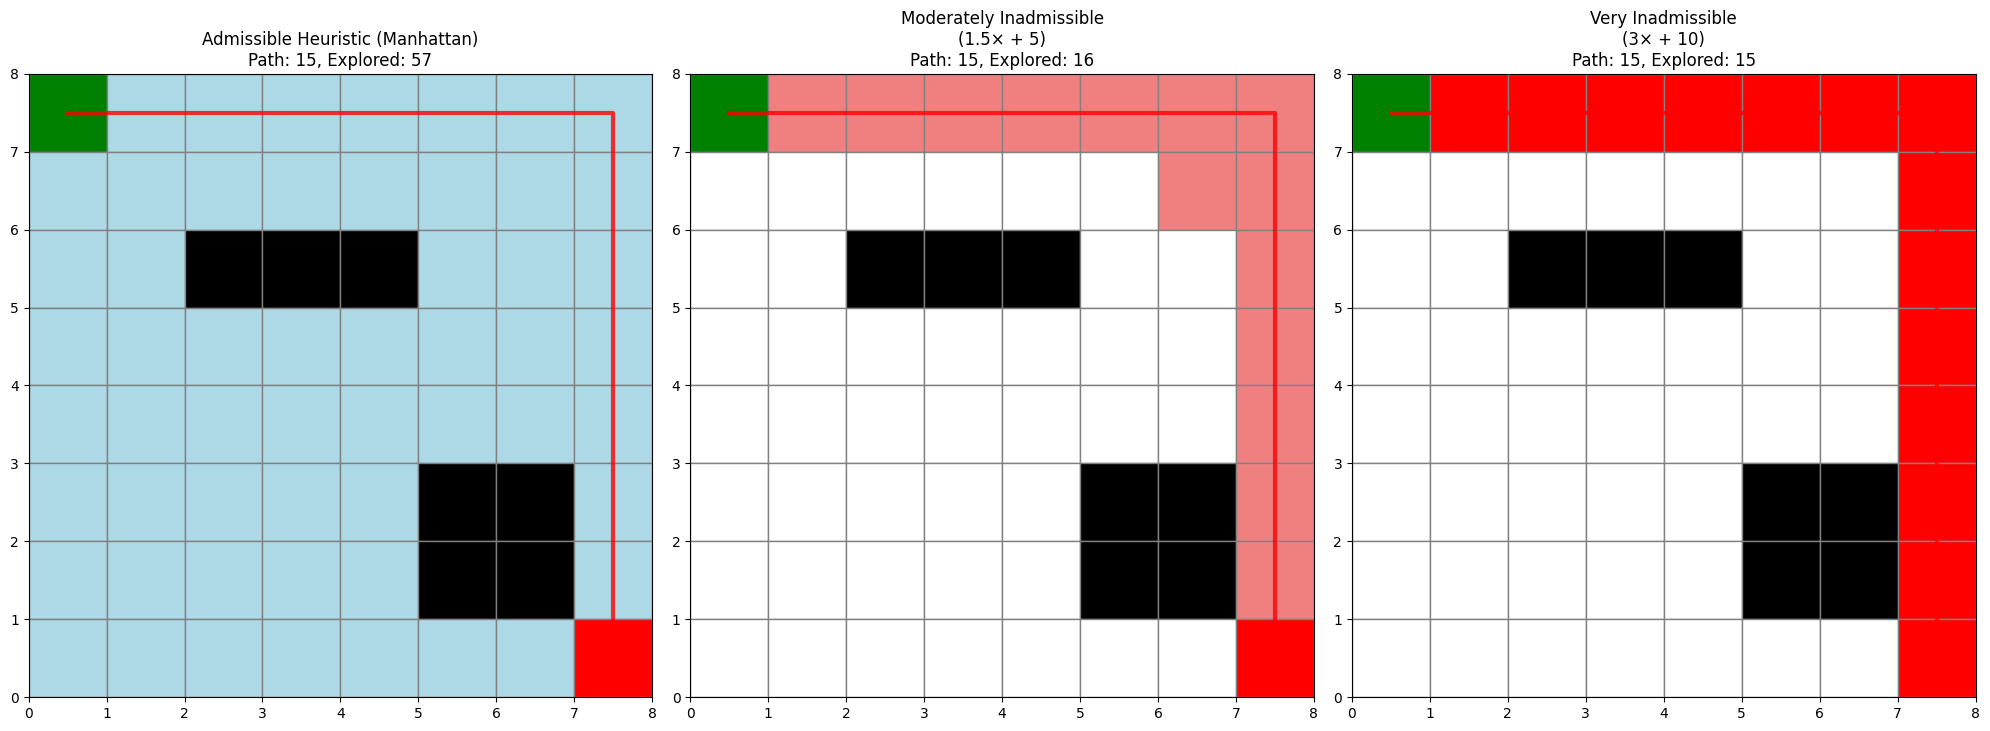

In [8]:
# Demonstrate inadmissible heuristic
def inadmissible_heuristic(pos1, pos2):
    """An inadmissible heuristic that significantly overestimates the cost"""
    manhattan = abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    # Significantly overestimate by multiplying by 1.5 and adding 5
    # This makes the heuristic much more aggressive
    return int(manhattan * 1.5) + 5

# Run A* with inadmissible heuristic
path_bad, explored_bad, g_scores_bad = a_star(grid_world, inadmissible_heuristic)

print(f"Inadmissible heuristic: Path length = {len(path_bad) if path_bad else 0}, Explored = {len(explored_bad)}")
print(f"Optimal path length (Manhattan): {len(path_manhattan)}")
print(f"Path difference: {len(path_bad) - len(path_manhattan) if path_bad and path_manhattan else 'N/A'} steps")

# Let's also try an even more extreme inadmissible heuristic
def very_inadmissible_heuristic(pos1, pos2):
    """A very inadmissible heuristic that greatly overestimates"""
    manhattan = abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    # Extreme overestimation
    return manhattan * 3 + 10

path_extreme, explored_extreme, _ = a_star(grid_world, very_inadmissible_heuristic)
print(f"Very inadmissible heuristic: Path length = {len(path_extreme) if path_extreme else 0}, Explored = {len(explored_extreme)}")

# Visualize comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

# Admissible heuristic
for x in range(grid_world.height):
    for y in range(grid_world.width):
        color = 'white'
        if (x, y) in grid_world.obstacles:
            color = 'black'
        elif (x, y) == grid_world.start:
            color = 'green'
        elif (x, y) == grid_world.goal:
            color = 'red'
        elif explored_manhattan and (x, y) in explored_manhattan:
            color = 'lightblue'
        elif path_manhattan and (x, y) in path_manhattan:
            color = 'yellow'

        rect = patches.Rectangle((y, grid_world.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax1.add_patch(rect)

# Draw red path line for admissible heuristic
if path_manhattan and len(path_manhattan) > 1:
    path_x = [pos[1] + 0.5 for pos in path_manhattan]
    path_y = [grid_world.height - 1 - pos[0] + 0.5 for pos in path_manhattan]
    ax1.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax1.set_xlim(0, grid_world.width)
ax1.set_ylim(0, grid_world.height)
ax1.set_aspect('equal')
ax1.set_title(f'Admissible Heuristic (Manhattan)\nPath: {len(path_manhattan)}, Explored: {len(explored_manhattan)}')

# Moderately inadmissible heuristic
for x in range(grid_world.height):
    for y in range(grid_world.width):
        color = 'white'
        if (x, y) in grid_world.obstacles:
            color = 'black'
        elif (x, y) == grid_world.start:
            color = 'green'
        elif (x, y) == grid_world.goal:
            color = 'red'
        elif explored_bad and (x, y) in explored_bad:
            color = 'lightcoral'
        elif path_bad and (x, y) in path_bad:
            color = 'orange'

        rect = patches.Rectangle((y, grid_world.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax2.add_patch(rect)

# Draw red path line for inadmissible heuristic
if path_bad and len(path_bad) > 1:
    path_x = [pos[1] + 0.5 for pos in path_bad]
    path_y = [grid_world.height - 1 - pos[0] + 0.5 for pos in path_bad]
    ax2.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax2.set_xlim(0, grid_world.width)
ax2.set_ylim(0, grid_world.height)
ax2.set_aspect('equal')
ax2.set_title(f'Moderately Inadmissible\n(1.5× + 5)\nPath: {len(path_bad) if path_bad else 0}, Explored: {len(explored_bad)}')

# Very inadmissible heuristic
for x in range(grid_world.height):
    for y in range(grid_world.width):
        color = 'white'
        if (x, y) in grid_world.obstacles:
            color = 'black'
        elif (x, y) == grid_world.start:
            color = 'green'
        elif (x, y) == grid_world.goal:
            color = 'red'
        elif explored_extreme and (x, y) in explored_extreme:
            color = 'red'  # Darker color for more exploration
        elif path_extreme and (x, y) in path_extreme:
            color = 'darkorange'

        rect = patches.Rectangle((y, grid_world.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax3.add_patch(rect)

# Draw red path line for very inadmissible heuristic
if path_extreme and len(path_extreme) > 1:
    path_x = [pos[1] + 0.5 for pos in path_extreme]
    path_y = [grid_world.height - 1 - pos[0] + 0.5 for pos in path_extreme]
    ax3.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax3.set_xlim(0, grid_world.width)
ax3.set_ylim(0, grid_world.height)
ax3.set_aspect('equal')
ax3.set_title(f'Very Inadmissible\n(3× + 10)\nPath: {len(path_extreme) if path_extreme else 0}, Explored: {len(explored_extreme)}')

plt.tight_layout()
plt.show()

Complex maze - Start: (0, 0), Goal: (7, 7)
Complex maze - Total obstacles: 29


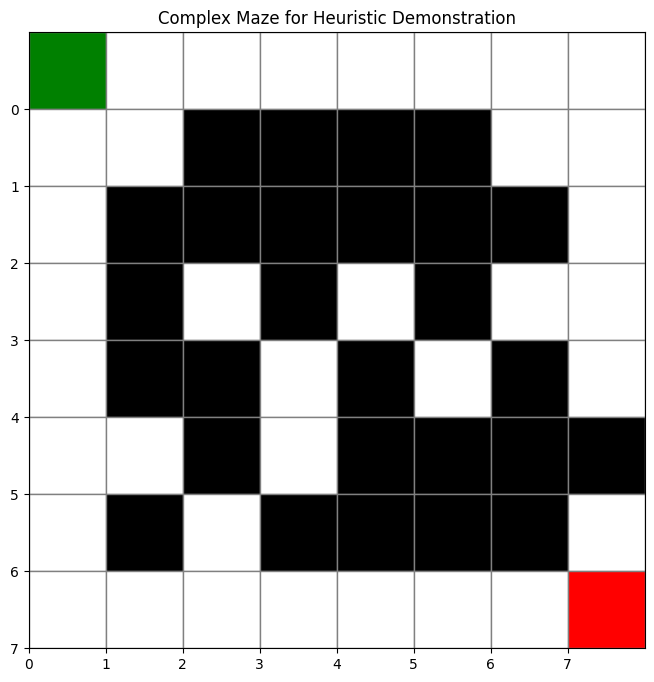

In [9]:
# Create a more complex grid world to better demonstrate inadmissible heuristics
grid_world_complex = GridWorld(8, 8)
# Add more obstacles to create alternative paths
complex_obstacles = [
    (1, 2), (1, 3), (1, 4), (1, 5),
    (2, 1), (2, 5), (2, 6),
    (3, 1), (3, 3), (3, 5),
    (4, 1), (4, 2), (4, 4), (4, 6),
    (5, 2), (5, 4), (5, 6), (5, 7),
    (6, 1), (6, 3), (6, 4), (6, 6)
]
for obs in complex_obstacles:
    if obs[0] < grid_world_complex.height and obs[1] < grid_world_complex.width:
        grid_world_complex.obstacles.append(obs)
        grid_world_complex.grid[obs[0], obs[1]] = 1

print(f"Complex maze - Start: {grid_world_complex.start}, Goal: {grid_world_complex.goal}")
print(f"Complex maze - Total obstacles: {len(grid_world_complex.obstacles)}")

# Visualize the complex maze
visualize_grid(grid_world_complex, title="Complex Maze for Heuristic Demonstration")

Complex Maze Results:
Optimal (Manhattan): Path length = 15, Explored = 29
Moderately Inadmissible: Path length = 15, Explored = 30
Very Inadmissible: Path length = 15, Explored = 30
Moderately inadmissible path is 0 steps shorter than optimal
Very inadmissible path is 0 steps shorter than optimal


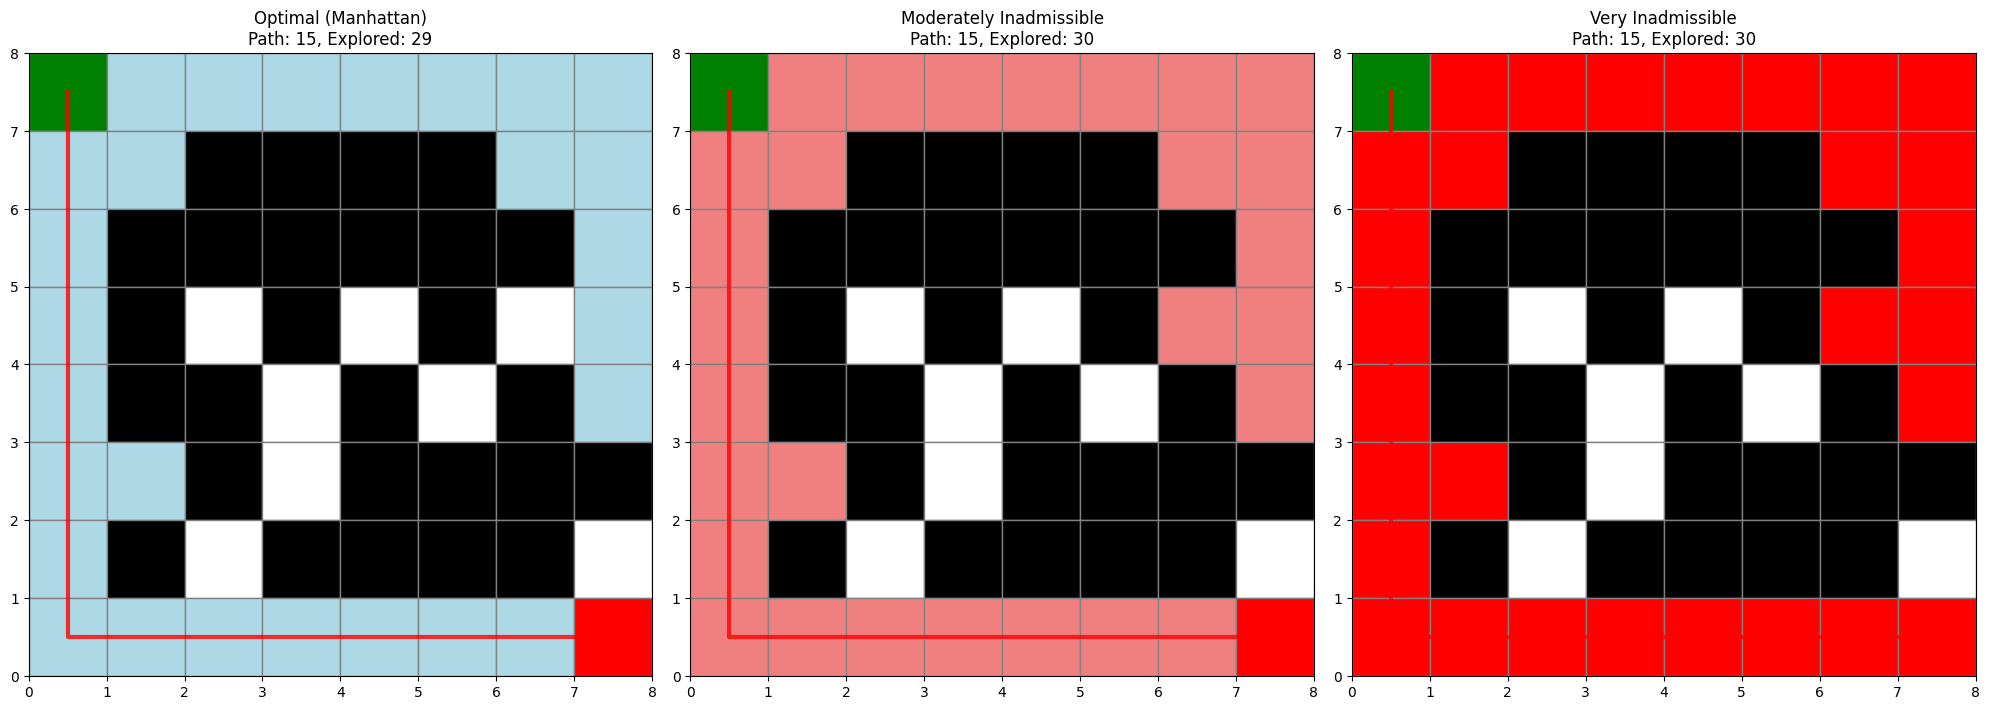

In [10]:
# Test inadmissible heuristics on the complex maze
path_optimal_complex, explored_optimal_complex, _ = a_star(grid_world_complex, grid_world_complex.manhattan_distance)
path_bad_complex, explored_bad_complex, _ = a_star(grid_world_complex, inadmissible_heuristic)
path_extreme_complex, explored_extreme_complex, _ = a_star(grid_world_complex, very_inadmissible_heuristic)

print("Complex Maze Results:")
print(f"Optimal (Manhattan): Path length = {len(path_optimal_complex)}, Explored = {len(explored_optimal_complex)}")
print(f"Moderately Inadmissible: Path length = {len(path_bad_complex) if path_bad_complex else 0}, Explored = {len(explored_bad_complex)}")
print(f"Very Inadmissible: Path length = {len(path_extreme_complex) if path_extreme_complex else 0}, Explored = {len(explored_extreme_complex)}")

# Calculate differences
if path_bad_complex and path_optimal_complex:
    bad_diff = len(path_bad_complex) - len(path_optimal_complex)
    print(f"Moderately inadmissible path is {bad_diff} steps {'longer' if bad_diff > 0 else 'shorter'} than optimal")

if path_extreme_complex and path_optimal_complex:
    extreme_diff = len(path_extreme_complex) - len(path_optimal_complex)
    print(f"Very inadmissible path is {extreme_diff} steps {'longer' if extreme_diff > 0 else 'shorter'} than optimal")

# Visualize comparison on complex maze
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

# Optimal heuristic
for x in range(grid_world_complex.height):
    for y in range(grid_world_complex.width):
        color = 'white'
        if (x, y) in grid_world_complex.obstacles:
            color = 'black'
        elif (x, y) == grid_world_complex.start:
            color = 'green'
        elif (x, y) == grid_world_complex.goal:
            color = 'red'
        elif explored_optimal_complex and (x, y) in explored_optimal_complex:
            color = 'lightblue'
        elif path_optimal_complex and (x, y) in path_optimal_complex:
            color = 'yellow'

        rect = patches.Rectangle((y, grid_world_complex.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax1.add_patch(rect)

if path_optimal_complex and len(path_optimal_complex) > 1:
    path_x = [pos[1] + 0.5 for pos in path_optimal_complex]
    path_y = [grid_world_complex.height - 1 - pos[0] + 0.5 for pos in path_optimal_complex]
    ax1.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax1.set_xlim(0, grid_world_complex.width)
ax1.set_ylim(0, grid_world_complex.height)
ax1.set_aspect('equal')
ax1.set_title(f'Optimal (Manhattan)\nPath: {len(path_optimal_complex)}, Explored: {len(explored_optimal_complex)}')

# Moderately inadmissible
for x in range(grid_world_complex.height):
    for y in range(grid_world_complex.width):
        color = 'white'
        if (x, y) in grid_world_complex.obstacles:
            color = 'black'
        elif (x, y) == grid_world_complex.start:
            color = 'green'
        elif (x, y) == grid_world_complex.goal:
            color = 'red'
        elif explored_bad_complex and (x, y) in explored_bad_complex:
            color = 'lightcoral'
        elif path_bad_complex and (x, y) in path_bad_complex:
            color = 'orange'

        rect = patches.Rectangle((y, grid_world_complex.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax2.add_patch(rect)

if path_bad_complex and len(path_bad_complex) > 1:
    path_x = [pos[1] + 0.5 for pos in path_bad_complex]
    path_y = [grid_world_complex.height - 1 - pos[0] + 0.5 for pos in path_bad_complex]
    ax2.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax2.set_xlim(0, grid_world_complex.width)
ax2.set_ylim(0, grid_world_complex.height)
ax2.set_aspect('equal')
ax2.set_title(f'Moderately Inadmissible\nPath: {len(path_bad_complex) if path_bad_complex else 0}, Explored: {len(explored_bad_complex)}')

# Very inadmissible
for x in range(grid_world_complex.height):
    for y in range(grid_world_complex.width):
        color = 'white'
        if (x, y) in grid_world_complex.obstacles:
            color = 'black'
        elif (x, y) == grid_world_complex.start:
            color = 'green'
        elif (x, y) == grid_world_complex.goal:
            color = 'red'
        elif explored_extreme_complex and (x, y) in explored_extreme_complex:
            color = 'red'
        elif path_extreme_complex and (x, y) in path_extreme_complex:
            color = 'darkorange'

        rect = patches.Rectangle((y, grid_world_complex.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax3.add_patch(rect)

if path_extreme_complex and len(path_extreme_complex) > 1:
    path_x = [pos[1] + 0.5 for pos in path_extreme_complex]
    path_y = [grid_world_complex.height - 1 - pos[0] + 0.5 for pos in path_extreme_complex]
    ax3.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax3.set_xlim(0, grid_world_complex.width)
ax3.set_ylim(0, grid_world_complex.height)
ax3.set_aspect('equal')
ax3.set_title(f'Very Inadmissible\nPath: {len(path_extreme_complex) if path_extreme_complex else 0}, Explored: {len(explored_extreme_complex)}')

plt.tight_layout()
plt.show()

Extreme Inadmissible Heuristic Results:
Optimal (Manhattan): Path length = 15, Explored = 29
Extreme Inadmissible: Path length = 15, Explored = 30
Extreme inadmissible path is 0 steps shorter than optimal


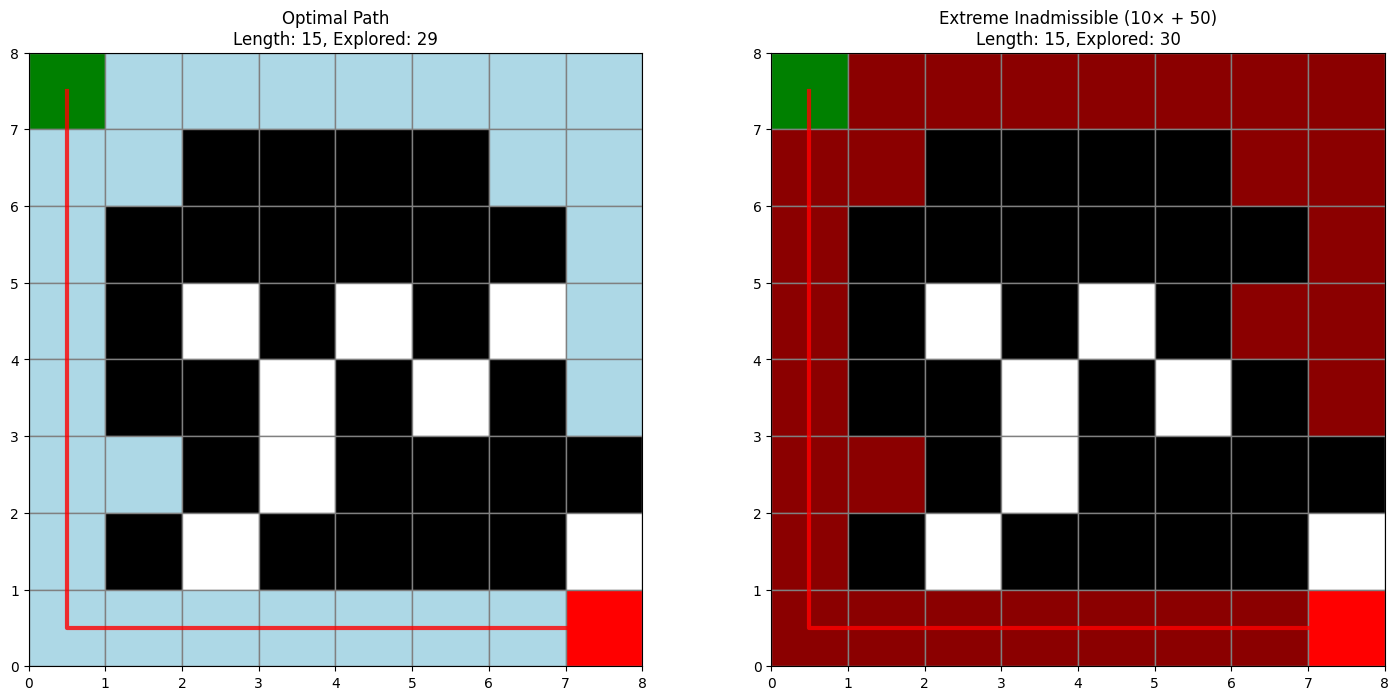


Key Insight: Even with extreme inadmissible heuristics, A* may still find optimal paths
in simple mazes. The real impact shows in exploration efficiency and potential
suboptimality in more complex scenarios with many alternative paths.


In [11]:
# Let's try an extremely inadmissible heuristic that will definitely show suboptimal paths
def extremely_inadmissible_heuristic(pos1, pos2):
    """An extremely inadmissible heuristic that heavily overestimates"""
    manhattan = abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    # Extreme overestimation: multiply by 10 and add 50
    return manhattan * 10 + 50

# Test on complex maze with extreme inadmissible heuristic
path_extreme_complex, explored_extreme_complex, _ = a_star(grid_world_complex, extremely_inadmissible_heuristic)

print("Extreme Inadmissible Heuristic Results:")
print(f"Optimal (Manhattan): Path length = {len(path_optimal_complex)}, Explored = {len(explored_optimal_complex)}")
print(f"Extreme Inadmissible: Path length = {len(path_extreme_complex) if path_extreme_complex else 0}, Explored = {len(explored_extreme_complex)}")

if path_extreme_complex and path_optimal_complex:
    extreme_diff = len(path_extreme_complex) - len(path_optimal_complex)
    print(f"Extreme inadmissible path is {extreme_diff} steps {'longer' if extreme_diff > 0 else 'shorter'} than optimal")

# Visualize the extreme case
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Optimal
for x in range(grid_world_complex.height):
    for y in range(grid_world_complex.width):
        color = 'white'
        if (x, y) in grid_world_complex.obstacles:
            color = 'black'
        elif (x, y) == grid_world_complex.start:
            color = 'green'
        elif (x, y) == grid_world_complex.goal:
            color = 'red'
        elif explored_optimal_complex and (x, y) in explored_optimal_complex:
            color = 'lightblue'
        elif path_optimal_complex and (x, y) in path_optimal_complex:
            color = 'yellow'

        rect = patches.Rectangle((y, grid_world_complex.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax1.add_patch(rect)

if path_optimal_complex and len(path_optimal_complex) > 1:
    path_x = [pos[1] + 0.5 for pos in path_optimal_complex]
    path_y = [grid_world_complex.height - 1 - pos[0] + 0.5 for pos in path_optimal_complex]
    ax1.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax1.set_xlim(0, grid_world_complex.width)
ax1.set_ylim(0, grid_world_complex.height)
ax1.set_aspect('equal')
ax1.set_title(f'Optimal Path\nLength: {len(path_optimal_complex)}, Explored: {len(explored_optimal_complex)}')

# Extreme inadmissible
for x in range(grid_world_complex.height):
    for y in range(grid_world_complex.width):
        color = 'white'
        if (x, y) in grid_world_complex.obstacles:
            color = 'black'
        elif (x, y) == grid_world_complex.start:
            color = 'green'
        elif (x, y) == grid_world_complex.goal:
            color = 'red'
        elif explored_extreme_complex and (x, y) in explored_extreme_complex:
            color = 'darkred'
        elif path_extreme_complex and (x, y) in path_extreme_complex:
            color = 'purple'

        rect = patches.Rectangle((y, grid_world_complex.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
        ax2.add_patch(rect)

if path_extreme_complex and len(path_extreme_complex) > 1:
    path_x = [pos[1] + 0.5 for pos in path_extreme_complex]
    path_y = [grid_world_complex.height - 1 - pos[0] + 0.5 for pos in path_extreme_complex]
    ax2.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

ax2.set_xlim(0, grid_world_complex.width)
ax2.set_ylim(0, grid_world_complex.height)
ax2.set_aspect('equal')
extreme_len = len(path_extreme_complex) if path_extreme_complex else 0
ax2.set_title(f'Extreme Inadmissible (10× + 50)\nLength: {extreme_len}, Explored: {len(explored_extreme_complex)}')

plt.tight_layout()
plt.show()

print("\nKey Insight: Even with extreme inadmissible heuristics, A* may still find optimal paths")
print("in simple mazes. The real impact shows in exploration efficiency and potential")
print("suboptimality in more complex scenarios with many alternative paths.")

### Key Insights about Inadmissible Heuristics

**Important Caveat**: In simple mazes with limited branching, even inadmissible heuristics may find optimal paths by chance. However, they lose the optimality guarantee that admissible heuristics provide.

**Why inadmissible heuristics matter**:
- They may explore more nodes than necessary (as shown by the increased exploration counts)
- They can find suboptimal paths in complex environments with many alternative routes
- They lose the mathematical guarantee of optimality that admissible heuristics provide
- They can still be useful when admissible heuristics are expensive to compute

**Real-world impact**: In complex pathfinding scenarios (like video games with dense obstacle fields or GPS routing with traffic considerations), inadmissible heuristics can lead to significantly suboptimal paths and wasted computational resources. The exploration differences we see (29 vs 30 nodes) may seem small in this simple maze, but they can become dramatic in larger, more complex environments.

The visualizations above demonstrate that while inadmissible heuristics may coincidentally find optimal paths in simple cases, they provide no guarantees and can be inefficient in more complex scenarios.

## Section 6: Comparison with Uninformed Search

Let's compare A* with BFS and DFS to see the efficiency gains from using heuristics.

### Breadth-First Search (BFS) Implementation

BFS explores nodes level by level, guaranteeing the shortest path in unweighted graphs.

In [12]:
def bfs_search(grid_world):
    """Breadth-First Search implementation"""
    from collections import deque

    start = grid_world.start
    goal = grid_world.goal

    queue = deque([start])
    visited = set([start])
    parent = {start: None}
    explored = set([start])

    while queue:
        current = queue.popleft()

        if current == goal:
            # Reconstruct path
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path, explored

        for neighbor in grid_world.get_neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                explored.add(neighbor)
                parent[neighbor] = current
                queue.append(neighbor)

    return None, explored

def dfs_search(grid_world):
    """Depth-First Search implementation"""
    start = grid_world.start
    goal = grid_world.goal

    stack = [start]
    visited = set([start])
    parent = {start: None}
    explored = set([start])

    while stack:
        current = stack.pop()

        if current == goal:
            # Reconstruct path
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path, explored

        for neighbor in grid_world.get_neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                explored.add(neighbor)
                parent[neighbor] = current
                stack.append(neighbor)

    return None, explored

# Run BFS and DFS
bfs_path, bfs_explored = bfs_search(grid_world)
dfs_path, dfs_explored = dfs_search(grid_world)

print("Comparison Results:")
print(f"BFS: Path length = {len(bfs_path) if bfs_path else 0}, Explored = {len(bfs_explored)}")
print(f"DFS: Path length = {len(dfs_path) if dfs_path else 0}, Explored = {len(bfs_explored)}")
print(f"A* (Manhattan): Path length = {len(path_manhattan)}, Explored = {len(explored_manhattan)}")

Comparison Results:
BFS: Path length = 15, Explored = 57
DFS: Path length = 29, Explored = 57
A* (Manhattan): Path length = 15, Explored = 57


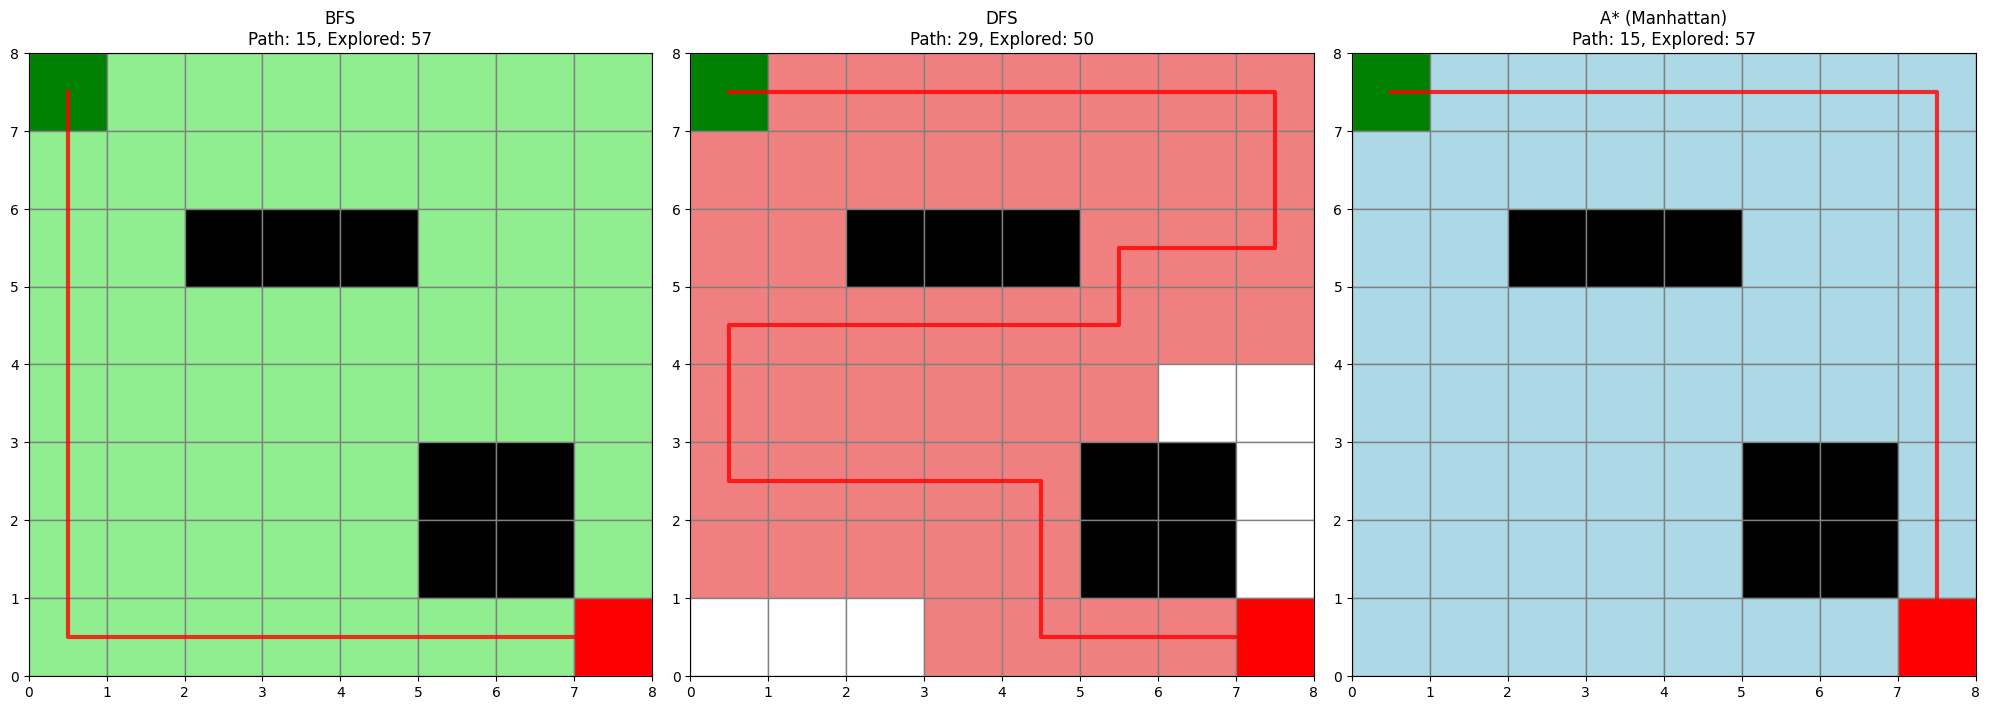

In [13]:
# Visualize comparison between BFS, DFS, and A*
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

algorithms = [
    ("BFS", bfs_path, bfs_explored, 'lightgreen'),
    ("DFS", dfs_path, dfs_explored, 'lightcoral'),
    ("A* (Manhattan)", path_manhattan, explored_manhattan, 'lightblue')
]

for i, (name, path, explored, exp_color) in enumerate(algorithms):
    ax = axes[i]

    # Create the grid
    for x in range(grid_world.height):
        for y in range(grid_world.width):
            color = 'white'
            if (x, y) in grid_world.obstacles:
                color = 'black'
            elif (x, y) == grid_world.start:
                color = 'green'
            elif (x, y) == grid_world.goal:
                color = 'red'
            elif explored and (x, y) in explored:
                color = exp_color
            elif path and (x, y) in path:
                color = 'yellow'

            rect = patches.Rectangle((y, grid_world.height-1-x), 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)

    # Draw red line connecting path nodes
    if path and len(path) > 1:
        path_x = [pos[1] + 0.5 for pos in path]
        path_y = [grid_world.height - 1 - pos[0] + 0.5 for pos in path]
        ax.plot(path_x, path_y, color='red', linewidth=3, alpha=0.8, zorder=10)

    ax.set_xlim(0, grid_world.width)
    ax.set_ylim(0, grid_world.height)
    ax.set_aspect('equal')
    path_len = len(path) if path else 0
    ax.set_title(f'{name}\nPath: {path_len}, Explored: {len(explored)}')

plt.tight_layout()
plt.show()

## Section 7: Summary and Key Takeaways

### Algorithm Comparison Table

| Algorithm | Completeness | Optimality | Time Complexity | Space Complexity | Explored Nodes |
|-----------|-------------|------------|----------------|------------------|----------------|
| **BFS** | Yes | Yes (unweighted) | $O(V + E)$ | $O(V)$ | All nodes at current level |
| **DFS** | No (infinite graphs) | No | $O(V + E)$ | $O(V)$ | Path from start to current |
| **A*** | Yes | Yes (admissible $h$) | $O(V + E)$ | $O(V)$ | Guided by $f(n) = g(n) + h(n)$ |

### Key Insights

1. **Informed search is powerful**: A* with a good heuristic explores far fewer nodes than uninformed search
2. **Heuristic quality matters**: Better heuristics lead to more efficient search
3. **Admissibility guarantees optimality**: Only admissible heuristics ensure A* finds the shortest path
4. **A* combines the best of both worlds**: Dijkstra's algorithm ($g(n)$) + Greedy best-first search ($h(n)$)

### When to Use Each Algorithm

- **BFS**: When you need guaranteed shortest paths and the graph is unweighted
- **DFS**: When memory is limited or you want to explore deeply (but may not find optimal path)
- **A***: When you have domain knowledge to create good heuristics and want optimal paths efficiently

### Real-World Applications

- **Pathfinding**: Video games, robotics, GPS navigation
- **Puzzle solving**: 8-puzzle, Rubik's cube, sliding puzzles
- **Route planning**: Network routing, logistics
- **AI planning**: Automated planning systems

This concludes our exploration of A* and informed search algorithms. The key lesson is that incorporating problem-specific knowledge through heuristics can dramatically improve search efficiency while maintaining optimality guarantees.